In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:

# Load SIFT detector
sift = cv2.SIFT_create()

In [6]:
products_description = {
    '0.jpg': 'Nesquik no scritte',
    '1.jpg': 'ChocoKrave blu',
    '2.jpg': 'CornFlakes',
    '3.jpg': 'ChokoGoal',
    '4.jpg': 'SlimChocolate',
    '5.jpg': 'Nesquik cereali',
    '6.jpg': 'Nesquik duo',
    '7.jpg': 'CocoPops risociok',
    '8.jpg': 'CocoPops palline rosso',
    '9.jpg': 'SpecialK classic',
    '10.jpg': 'SpecialK fondente',
    '11.jpg': 'ChocoKrave',
    '12.jpg': 'Fitness fruits',
    '13.jpg': 'Fitness azzurro',
    '14.jpg': 'Chocapic',
    '15.jpg': 'CocoPops rotelle',
    '16.jpg': 'MielPops nocciola',
    '17.jpg': 'MielPops anellini',
    '18.jpg': 'CountryCrisp',
    '19.jpg': 'CountryCrisp nuts azzurro',
    '20.jpg': 'SpecialK frutti rossi',
    '21.jpg': 'RiceKrispies',
    '22.jpg': 'Cheerios',
    '23.jpg': 'SpecialK classic',
    '24.jpg': 'Fitness pink edition',
    '25.jpg': 'CocoPops palline rosso con regalo',
    '26.jpg': 'Nesquik duo con regalo fucsia',
}

In [7]:
def match(model, scene, threshold=0.75, k=2):
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(model, scene, k)
    #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good_matches = []
    for m,n in matches:
        if m.distance < threshold * n.distance: #  if m.distance/n.distance < Threshold:
            good_matches.append(m)
            
    return good_matches

def nms(boxes, scores, overlapThresh):
    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # Initialize the list of picked indexes
    pick = []

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # Compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index
        # value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box
        # and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have a large overlap
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked
    return boxes[pick], pick


In [8]:
def image_to_color_bins_lab(image_path, grid_size=(4, 4), roi=None):
    # Read the image and convert it to the LAB color space
    image = cv2.imread(image_path)
    
        # If a region of interest is provided, crop the image to that region
    if roi is not None:
        x, y, w, h = roi
        image = image[y:y+h, x:x+w]
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image_height, image_width, _ = lab_image.shape

    # Calculate the size of each bin
    bin_height = image_height // grid_size[0]
    bin_width = image_width // grid_size[1]
    # List to hold the average color per bin
    average_colors = []

    # Loop over the grid
    for i in range(0, image_height, bin_height):
        if i + bin_height > image_height:
            continue
        for j in range(0, image_width, bin_width):
            if j + bin_width > image_width:
                continue
            # Compute the boundaries of the bin
            bin_roi = lab_image[i:i+bin_height, j:j+bin_width]

            # Compute the average color of the bin
            average_color = cv2.mean(bin_roi)[:3]  # Slice to exclude the alpha channel if present
            average_colors.append(average_color)
    # return np.array(average_colors)
    v = np.array(average_colors)
    return cv2.normalize(v, v).flatten()

def cosine_distance(a, b):
    # Compute the cosine similarity
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    # Compute the cosine distance
    distance = 1 - cosine_similarity
    return distance

def compute_iou(rect_a, rect_b):
    # Unpack the coordinates
    min_x_a, max_x_a, min_y_a, max_y_a = rect_a
    min_x_b, max_x_b, min_y_b, max_y_b = rect_b

    # Calculate the intersection coordinates
    intersection_min_x = max(min_x_a, min_x_b)
    intersection_max_x = min(max_x_a, max_x_b)
    intersection_min_y = max(min_y_a, min_y_b)
    intersection_max_y = min(max_y_a, max_y_b)

    # Calculate the area of intersection
    intersection_area = max(0, intersection_max_x - intersection_min_x) * max(0, intersection_max_y - intersection_min_y)

    # Calculate the area of both rectangles
    area_a = (max_x_a - min_x_a) * (max_y_a - min_y_a)
    area_b = (max_x_b - min_x_b) * (max_y_b - min_y_b)

    # Calculate the area of the union
    union_area = area_a + area_b - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    
    return iou

In [9]:
def calc_histogram(image_path, bins_per_channel=32, roi=None):
    # Read the image
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    
    # If a region of interest is provided, crop the image to that region
    if roi is not None:
        x, y, w, h = roi
        image = image[y:y+h, x:x+w]
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()

    # Calculate the histogram for each color channel using the specified number of bins
    histogram = cv2.calcHist([image], [0, 1, 2], None, [bins_per_channel]*3, [0, 256, 0, 256, 0, 256])
    # Normalize and flatten the histogram for comparison
    return cv2.normalize(histogram, histogram).flatten(), image

# Function to compare two histograms
def compare_histograms(hist1, hist2, method=cv2.HISTCMP_CORREL):
    score = cv2.compareHist(hist1, hist2, method)
    return score

SCENE e1.png
	Product 26.jpg (Nesquik duo con regalo fucsia), found IoU of 89.5% with product 0.jpg. Keeping 0.jpg since it has 294 VS 55 matches of product 26.jpg
	Product 0.jpg (Nesquik no scritte) - Instance found:
		Instance 1 {position: (162.50, 219.50), width: 311.00px, height: 439.00px}, good matches are 294.
	Product 11.jpg (ChocoKrave) - Instance found:
		Instance 1 {position: (443.00, 182.50), width: 300.00px, height: 365.00px}, good matches are 79.


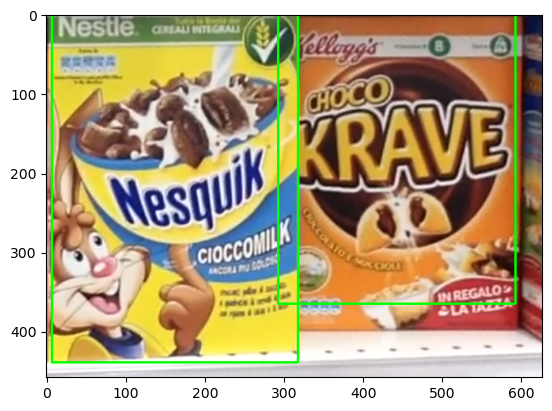

SCENE e2.png
	Product 26.jpg (Nesquik duo con regalo fucsia), found IoU of 58.5% with product 0.jpg. Keeping 26.jpg since it has 184 VS 98 matches of product 0.jpg
	Product 24.jpg (Fitness pink edition) - Instance found:
		Instance 1 {position: (168.50, 232.50), width: 337.00px, height: 465.00px}, good matches are 204.
	Product 26.jpg (Nesquik duo con regalo fucsia) - Instance found:
		Instance 1 {position: (539.50, 231.50), width: 337.00px, height: 463.00px}, good matches are 184.
	Product 25.jpg (CocoPops palline rosso con regalo) - Instance found:
		Instance 1 {position: (876.00, 231.50), width: 324.00px, height: 449.00px}, good matches are 199.


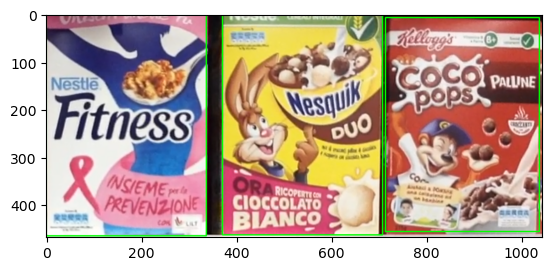

SCENE e3.png
	Product 0.jpg (Nesquik no scritte) - Instance found:
		Instance 1 {position: (170.00, 232.50), width: 328.00px, height: 441.00px}, good matches are 274.
	Product 1.jpg (ChocoKrave blu) - Instance found:
		Instance 1 {position: (817.00, 201.00), width: 310.00px, height: 402.00px}, good matches are 133.
	Product 11.jpg (ChocoKrave) - Instance found:
		Instance 1 {position: (476.00, 194.50), width: 312.00px, height: 389.00px}, good matches are 55.


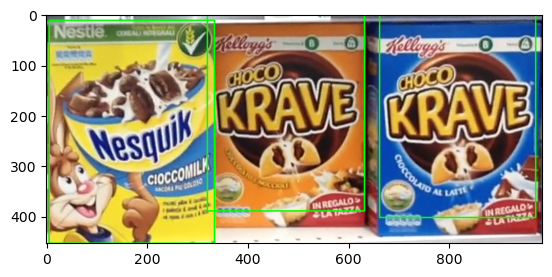

SCENE e4.png
	Product 0.jpg (Nesquik no scritte) - Instance found:
		Instance 1 {position: (161.00, 735.50), width: 322.00px, height: 441.00px}, good matches are 221.
	Product 11.jpg (ChocoKrave) - Instance found:
		Instance 1 {position: (463.00, 694.00), width: 310.00px, height: 400.00px}, good matches are 81.
	Product 26.jpg (Nesquik duo con regalo fucsia) - Instance found:
		Instance 1 {position: (204.50, 222.00), width: 345.00px, height: 444.00px}, good matches are 173.
	Product 25.jpg (CocoPops palline rosso con regalo) - Instance found:
		Instance 1 {position: (551.50, 218.00), width: 325.00px, height: 436.00px}, good matches are 158.


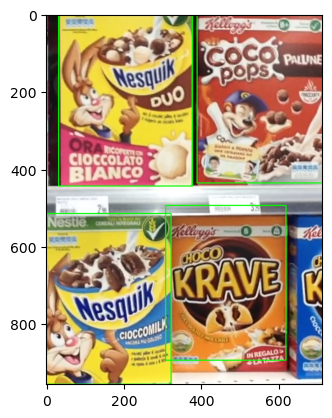

SCENE e5.png
	Product 19.jpg (CountryCrisp nuts azzurro) - Instance found:
		Instance 1 {position: (502.50, 191.00), width: 301.00px, height: 382.00px}, good matches are 154.
	Product 25.jpg (CocoPops palline rosso con regalo) - Instance found:
		Instance 1 {position: (162.00, 228.00), width: 324.00px, height: 452.00px}, good matches are 171.


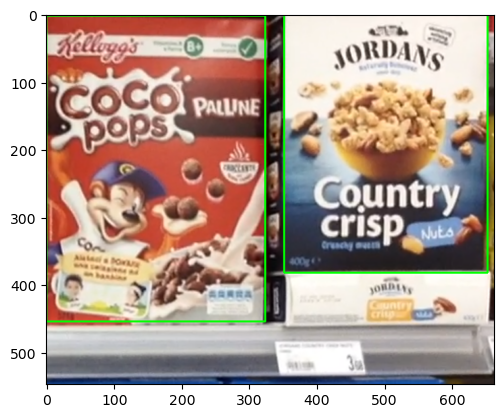

In [10]:

# Load product images and extract features
product_images = ['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']
# product_images = ['0.jpg', '11.jpg']
product_features = {}

bins = 128
# for img_name in product_images:
#     img = cv2.imread('images/models/' + img_name, cv2.IMREAD_GRAYSCALE)
#     kp, des = sift.detectAndCompute(img, None)
#     product_features[img_name] = (kp, des)

# For each scene image
scene_images = ['e1.png', 'e2.png', 'e3.png', 'e4.png', 'e5.png']
for scene_img_name in scene_images[:]:
    scene_img = cv2.imread('images/scenes/' + scene_img_name, cv2.IMREAD_GRAYSCALE)
    scene_img_color = cv2.imread('images/scenes/' + scene_img_name)

    results = dict()
    print(f'SCENE {scene_img_name}\n')
    # for img_name, (kp, des) in product_features.items():
    boxes = []
    scores = []
    for img_name in product_images:
        img = cv2.imread('images/models/' + img_name, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)
        product_features[img_name] = (kp, des)
        found = False
        
        detection_mask = np.ones(scene_img.shape[:2], dtype=np.uint8)

        while not found:
            scene_kp, scene_des = sift.detectAndCompute(scene_img, detection_mask)

            good_matches = match(des, scene_des, threshold=0.6)
            # print(f"\tProduct {img_name} - good matches are {len(good_matches)}. Dynamic threshold is {(dynamic_threshold)}")

            # If sufficient matches found, calculate homography and bounding box
            if len(good_matches) >= 50:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                
                # Transform the corners of the product image to get the bounding box in the scene image
                h, w = img.shape
                pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
                scene_pts = cv2.perspectiveTransform(pts, M)
                # Flatten the list of points
                scene_pts = scene_pts.reshape(-1, 2)
                
                scene_img = cv2.polylines(scene_img, [np.int32(scene_pts)], True, (0, 255, 0), 3, cv2.LINE_AA)
                # Get the bounding box parameters
                min_x, min_y = np.min(scene_pts, axis=0)
                max_x, max_y = np.max(scene_pts, axis=0)
                
                min_x = int(max(min_x, 0))
                min_y = int(max(min_y, 0))
                max_x = int(min(max_x, scene_img.shape[1]))
                max_y = int(min(max_y, scene_img.shape[0]))
                
                # Calculate the center, width, and height
                width = max_x - min_x
                height = max_y - min_y
                
                if width > height:
                    break
                    
                product_hist, product_img = calc_histogram('images/models/' + img_name, bins_per_channel=bins)
                patch_hist, patch_img = calc_histogram('images/scenes/' + scene_img_name, roi=(min_x, min_y, width, height), bins_per_channel=bins)
                color_score = compare_histograms(product_hist, patch_hist, cv2.HISTCMP_INTERSECT)
    
                # Now, you can calculate the color bins for two images in the LAB color space
                grid_size = (8, 8)  # Example grid size
                product_colors = image_to_color_bins_lab('images/models/' + img_name, grid_size=grid_size)
                patch_colors = image_to_color_bins_lab('images/scenes/' + scene_img_name, roi=(min_x, min_y, width, height), grid_size=grid_size)
                # Continue with comparison as before...
                color_distance = cosine_distance(product_colors, patch_colors)
                
                if color_distance >= 0.020:
                    detection_mask[min_y:max_y, min_x:max_x] = 0
                    scene_kp, scene_des = sift.detectAndCompute(scene_img, detection_mask)
                    # plt.imshow(detection_mask)
                    # plt.show()
                    # print(f'\tProduct {img_name} ({products_description[img_name]}) - color distance is too high! {color_distance:.3f}')
                    continue
                else:
                    found = True
                    
                to_remove = False
                for result in results.copy():
                    iou = compute_iou(result, (min_x, max_x, min_y, max_y))
                    if iou >= 0.5:
                        if results[result]['matches'] > len(good_matches):
                            print(f'\tProduct {img_name} ({products_description[img_name]}), found IoU of {100 * iou:.1f}% with product {results[result]["product"]}. Keeping {results[result]["product"]} since it has {results[result]["matches"]} VS {len(good_matches)} matches of product {img_name}')
                            to_remove = True
                        else:
                            print(f'\tProduct {img_name} ({products_description[img_name]}), found IoU of {100 * iou:.1f}% with product {results[result]["product"]}. Keeping {img_name} since it has {len(good_matches)} VS {results[result]["matches"]} matches of product {results[result]["product"]}')
                            results.pop(result)
                        
                if not to_remove:  
                    results[(min_x, max_x, min_y, max_y)] = {'matches': len(good_matches), 'product': img_name}
                # print(results)
                # found = True
                # _, axs = plt.subplots(1, 2, figsize=(5, 10))
                # axs = axs.flatten()
                # for img, ax in zip([cv2.cvtColor(product_img, cv2.COLOR_BGR2RGB), cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)], axs):
                #     ax.imshow(img)
                # plt.show()
                # if color_score <= 1:
                #     continue
                
            else:
                found = True
                
    for result in results:
        min_x, max_x, min_y, max_y = result
        width = max_x - min_x
        height = max_y - min_y
        matches = results[result]['matches']
        product = results[result]['product']
        
        center_x = min_x + (width / 2)
        center_y = min_y + (height / 2)
        
        # Draw the bounding box
        # scene_img_color = cv2.polylines(scene_img_color, [np.int32(scene_pts)], True, (0, 255, 0), 3, cv2.LINE_AA)
        scene_img_color = cv2.rectangle(scene_img_color, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

        # Print the output
        print(f"\tProduct {product} ({products_description[product]}) - Instance found:")
        print(f"\t\tInstance 1 {{position: ({center_x:.2f}, {center_y:.2f}), width: {width:.2f}px, height: {height:.2f}px}}, good matches are {matches}.")
    plt.imshow(cv2.cvtColor(scene_img_color, cv2.COLOR_BGR2RGB))
    plt.show()
        # Display the scene image with all bounding boxes
    # cv2.imshow(f'Scene with Bounding Boxes - {scene_img_name}', scene_img_color)
    # cv2.waitKey(0)  # Wait for a key press to proceed
    # cv2.destroyAllWindows()  # Close the window after key press

# STEP 2

In [38]:
def map_to_hough_space(query_keypoints, train_keypoints, query_x_center, query_y_center):
    v = ((query_x_center - query_keypoints.pt[0]), (query_y_center - query_keypoints.pt[1]))
    scale_ratio = train_keypoints.size / query_keypoints.size
    delta_angle = train_keypoints.angle - query_keypoints.angle
    x_c = train_keypoints.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
    y_c = train_keypoints.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])

    return {
        'x_center': x_c,
        'y_center': y_c,
        'scale_ratio': scale_ratio,
        'delta_angle': delta_angle,
    }

def compute_bins(hough_space, query_shape, train_shape, bin_precision_factor=0.25, angle_bins=0.2):
    data_scale = np.array([entry['scale_ratio'] for entry in hough_space.values()])
    data_angle = np.array([entry['delta_angle'] for entry in hough_space.values()])

    # Using numpy to calculate histograms
    counts_scale, bins_scale = np.histogram(data_scale, bins='auto')
    img_scale = (bins_scale[np.argmax(counts_scale)] + bins_scale[np.argmax(counts_scale) + 1]) / 2

    x_bin_size = img_scale * query_shape[1] * bin_precision_factor
    y_bin_size = img_scale * query_shape[0] * bin_precision_factor
    x_bins = int(np.ceil(train_shape[1] / x_bin_size)) + 2
    y_bins = int(np.ceil(train_shape[0] / y_bin_size)) + 2
    x_min = train_shape[1] / 2 - x_bins / 2 * x_bin_size
    y_min = train_shape[0] / 2 - y_bins / 2 * y_bin_size

    angle_bin_size = np.std(data_angle) * bin_precision_factor
    scale_bin_size = np.std(data_scale) * bin_precision_factor
    scale_bins = int(np.ceil(2 / scale_bin_size))  # Assuming max scale is 2

    return {
        'x_bins': x_bins,
        'y_bins': y_bins,
        'x_min': x_min,
        'y_min': y_min,
        'x_bin_size': x_bin_size,
        'y_bin_size': y_bin_size,
        'scale_bins': scale_bins,
        'scale_min': 0,  # Scale min is 0 if the smallest scale_ratio is expected to be positive
        'scale_bin_size': scale_bin_size,
        'angle_min': np.mean(data_angle) - angle_bins / 2 * angle_bin_size,
        'angle_bin_size': angle_bin_size  
    }

def get_bin_indices(v, b, angle_bins=20):
    # Compute the bin indices for each dimension
    i = int(np.floor((v['x_c'] - b['x_min']) / b['x_bin_size']))
    j = int(np.floor((v['y_c'] - b['y_min']) / b['y_bin_size']))
    k = int(np.floor((v['delta_angle'] - b['angle_min']) / b['angle_bin_size']))
    l = int(np.floor((v['scale_ratio'] - b['scale_min']) / b['scale_bin_size']))
    
    # Ensure the indices are within the valid range
    valid_i = 0 <= i < b['x_bins']
    valid_j = 0 <= j < b['y_bins']
    valid_k = 0 <= k < angle_bins
    valid_l = 0 <= l < b['scale_bins']
    
    return i, j, k, l, valid_i and valid_j and valid_k and valid_l

def voting(b, h_s, angle_bins=20):
    # Initialize the accumulator array with zeros
    accumulator = np.zeros((b['x_bins'], b['y_bins'], angle_bins, b['scale_bins']))
    votes = {}

    # Iterate through the Hough space entries
    for idx, v in h_s.items():
        i, j, k, l, is_valid = get_bin_indices(v, b)
        
        # If the indices are valid, increment the accumulator and record the vote
        if is_valid:
            accumulator[i, j, k, l] += 1
            if (i, j, k, l) not in votes:
                votes[(i, j, k, l)] = []
            votes[(i, j, k, l)].append(idx)

    return accumulator, votes

In [39]:
images_dict = dict()

for image_name in scene_images:
    image = cv2.imread('images/scenes/' + image_name, cv2.IMREAD_GRAYSCALE)
    kp, des = sift.detectAndCompute(image, None)
    images_dict[image_name] = {
        'kp': kp,
        'des': des,
        'shape': image.shape[:2],
    }
for image_name in product_images:
    image = cv2.imread('images/models/' + image_name, cv2.IMREAD_GRAYSCALE)
    kp, des = sift.detectAndCompute(image, None)
    images_dict[image_name] = {
        'kp': kp,
        'des': des,
        'shape': image.shape[:2],
    }
    


In [33]:
product_images = ['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']
scene_images = ['m1.png', 'm2.png', 'm3.png', 'm4.png', 'm5.png']
product_images = ['26.jpg']
scene_images = ['m1.png']


In [ ]:
for scene_image_name in scene_images:
    correspondences = list()
    
    # Train 
    kp_scene, des_scene = images_dict[scene_image_name]['kp'], images_dict[scene_image_name]['desc']

    for product_image_name in product_images:
        # Query
        kp_product, des_product = images_dict[product_image_name]['kp'], images_dict[product_image_name]['desc']
        
        FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
        search_params = dict(checks = 50)
    
        # Initializing matcher
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_scene, des_product, 2)

        good_matches = dict()

        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches[m.queryIdx] = m.trainIdx
      
        query_xc = np.mean(list(kp_product[p].pt[0] for _, p in good_matches.items()))
        query_yc = np.mean(list(kp_product[p].pt[1] for _, p in good_matches.items()))
        
        hough_space = dict()

        for t_idx, q_idx in good_matches.items():
            hough_space[t_idx] = map_to_hough_space(kp_product[q_idx], kp_scene[t_idx], query_xc, query_yc)
    
        if len(hough_space) < HOUGH_T: 
            continue
        
        bins_values = compute_bins(hough_space, images_dict[product_image_name]['shape'], images_dict[scene_image_name]['shape'])
        accumulator, votes = voting(bins_values, hough_space)

        # compute local maxima of the 4-dimensional accumulator 
        mask = sk.local_maxima(accumulator)
        accumulator[mask != 1] = 0

        # store in a list all the correspondeces between query points and train points that voted for a local maxima 
        # the list contains: number of votes that a local maxima bin has received, name of query image, list of query and train keypoints which voted for that bin
        for b in list(np.argwhere(accumulator >= T_Q)): # thresholding the accumulator to come up with few maxima 
            keypoint_index_list = votes[tuple(b)] # all query keypoint who voted for a local maxima bin 
            correspondence_list = [(kp_train[k], kp_query[good_matches[k]]) for k in keypoint_index_list]
            global_correspondences.append([accumulator[tuple(b)], query_img, correspondence_list])


Scene m1.png, product 26.jpg, good matches are 358
The barycenter of the matched keypoints is at: (285, 268)


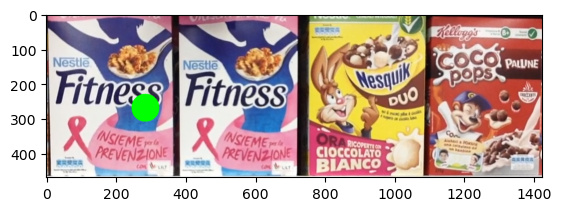

In [35]:
for scene_image in scene_images:
    scene = cv2.imread('images/scenes/' + scene_image, cv2.IMREAD_GRAYSCALE)
    scene_color = cv2.imread('images/scenes/' + scene_image)
    kp, des = sift.detectAndCompute(scene, None)
    
    for product_image in product_images:
        product = cv2.imread('images/models/' + product_image, cv2.IMREAD_GRAYSCALE)
        kp_product, des_product = sift.detectAndCompute(product, None)
        
        good_matches = match(des, des_product)
        print(f'Scene {scene_image}, product {product_image}, good matches are {len(good_matches)}')
        
        barycenter = compute_barycenter(good_matches, kp)
        if barycenter:
            print(f"The barycenter of the matched keypoints is at: {barycenter}")
            scene_color = cv2.circle(scene_color, barycenter, 40, (0, 255, 0), -1)

        else:
            print("No good matches found to compute the barycenter.")
        plt.imshow(cv2.cvtColor(scene_color, cv2.COLOR_BGR2RGB))
        plt.show()

In [16]:
good_matches[0]

< cv2.DMatch 0x7fb7e809d1d0>

In [17]:

# Example usage:
# Assuming 'good_matches' is a list of good matches returned by your `match` function
# and 'keypoints_scene' is a list of keypoints from the scene image detected by SIFT



The barycenter of the matched keypoints is at: (209.72267296716248, 534.1302968631802)


In [ ]:
models = dict()

for product_image in product_images:
    img = cv2.imread('images/models/' + product_image, cv2.IMREAD_GRAYSCALE)
    keypoints, des = sift.detectAndCompute(img, None)

    # Compute the barycenter of the model by averaging the positions of the keypoints
    barycenter = np.mean([kp.pt for kp in keypoints], axis=0)

    # Compute vectors from keypoints to the barycenter
    vectors_to_barycenter = []
    for kp in keypoints:
        vector = np.array(kp.pt) - barycenter
        vectors_to_barycenter.append((vector, kp.size))
    
    # Now you have your model which consists of vectors to the barycenter and sizes of keypoints
    model = {
        'barycenter': barycenter,
        'vectors_to_barycenter': vectors_to_barycenter,
        'descriptors': des,
        'keypoints': keypoints,
        'width': img.shape[0],
        'height': img.shape[1],
    }
    
    models[product_image] = model

In [ ]:
for scene_img_name in scene_images[:]:
    scene_image = cv2.imread('images/scenes/' + scene_img_name, cv2.IMREAD_GRAYSCALE)
    scene_img_color = cv2.imread('images/scenes/' + scene_img_name)

    results = dict()
    print(f'SCENE {scene_img_name}\n')

In [44]:
# import cv2
# import numpy as np
# 
# # Load the scene image
# scene_image_path = 'path_to_your_scene_image.jpg'  # Replace with the path to your scene image
# scene_image = cv2.imread(scene_image_path, cv2.IMREAD_GRAYSCALE)
# 
# # Check if the image is loaded correctly
# if scene_image is None:
#     raise ValueError("Could not open or find the scene image.")
# 
# # Load the model from the file
# model_file = 'model_data.npy'
# model = np.load(model_file, allow_pickle=True).item()

# Unpack the model's barycenter, vectors to the barycenter, and descriptors
barycenter = model['barycenter']
vectors_to_barycenter = model['vectors_to_barycenter']
model_descriptors = model['descriptors']
model_keypoints = model['keypoints']
model_height = model['height']
model_width = model['width']
# Detect SIFT features in the scene image
scene_keypoints, scene_descriptors = sift.detectAndCompute(scene_image, None)

# Create a BFMatcher object
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors between scene and model
matches = match(scene_descriptors, model_descriptors) # bf.match(scene_descriptors, model_descriptors)

# Initialize an accumulator for the votes in the Hough space (voting space)
hough_space = np.zeros(scene_image.shape[:2])

# Process each match
for match in matches:
    # Retrieve the scale and vector from the model for this match
    model_vector, model_scale = vectors_to_barycenter[match.trainIdx]

    # Get the scale of the keypoint in the scene
    scene_scale = scene_keypoints[match.queryIdx].size

    # Scale the model vector based on the scale change from model to scene
    scale_ratio = scene_scale / model_scale
    scaled_vector = model_vector * scale_ratio

    # Get the location of the keypoint in the scene
    scene_point = np.array(scene_keypoints[match.queryIdx].pt)

    # Estimate the barycenter position in the scene
    estimated_barycenter = scene_point + scaled_vector

    # Cast a vote in the Hough space
    estimated_y, estimated_x = int(estimated_barycenter[1]), int(estimated_barycenter[0])
    if 0 <= estimated_x < hough_space.shape[1] and 0 <= estimated_y < hough_space.shape[0]:
        hough_space[estimated_y, estimated_x] += 1

# Detect peaks in the Hough space to find the most voted barycenter positions
# This is a simplified way to find peaks, in practice, you would use a more robust method
threshold_votes = max(3, np.max(hough_space) * 0.5)
barycenter_candidates = np.argwhere(hough_space >= threshold_votes)

# Each candidate is a potential instance of the object in the scene
for candidate in barycenter_candidates:
    y, x = candidate
    print(f"Detected potential barycenter at ({x}, {y}) with {hough_space[y, x]} votes.")

Detected potential barycenter at (274, 49) with 3.0 votes.
Detected potential barycenter at (777, 347) with 3.0 votes.


In [46]:
def get_bounding_box(barycenter, avg_scale, model_bbox_size):
    """
    Calculate the bounding box in the scene based on the estimated barycenter and average scale.
    
    :param barycenter: The estimated position of the barycenter in the scene (x, y).
    :param avg_scale: The average scale factor between the model and the scene matches.
    :param model_bbox_size: The size of the bounding box in the model (width, height).
    :return: The top-left and bottom-right coordinates of the bounding box in the scene.
    """
    # Scale the model's bounding box size by the average scale
    scaled_bbox_width = model_bbox_size[0] * avg_scale
    scaled_bbox_height = model_bbox_size[1] * avg_scale
    
    # Calculate the top-left corner of the bounding box
    top_left_x = int(barycenter[0] - scaled_bbox_width / 2)
    top_left_y = int(barycenter[1] - scaled_bbox_height / 2)
    
    # Calculate the bottom-right corner of the bounding box
    bottom_right_x = int(barycenter[0] + scaled_bbox_width / 2)
    bottom_right_y = int(barycenter[1] + scaled_bbox_height / 2)
    
    return (top_left_x, top_left_y), (bottom_right_x, bottom_right_y)


# Assuming 'matches' is a list of matches from the scene to the model
# and 'model_keypoints' and 'scene_keypoints' are the keypoints from the model and scene
scale_changes = []
for match in matches:
    model_kp = model_keypoints[match.trainIdx]
    scene_kp = scene_keypoints[match.queryIdx]
    scale_changes.append(scene_kp.size / model_kp.size)
avg_scale = np.mean(scale_changes)

# Assuming 'model_bbox_size' is the (width, height) of the model's bounding box
model_bbox_size = (model_width, model_height)

# For each barycenter candidate, calculate the corresponding bounding box
for barycenter in barycenter_candidates:
    # Convert from (row, column) to (x, y)
    barycenter_pos = (barycenter[1], barycenter[0])
    top_left, bottom_right = get_bounding_box(barycenter_pos, avg_scale, model_bbox_size)
    
    # Draw the bounding box on the scene image for visualization
    cv2.rectangle(scene_image, top_left, bottom_right, (0, 255, 0), 2)

# Show the result
cv2.imshow('Detected Objects', scene_image)
cv2.waitKey(0)
cv2.destroyAllWindows()